In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
import os.path
from messaging.telegrambot import Bot
import telegram
import sys,os
#sys.path.append('../Sources') # Adding my own libs source
#from StackedAutoEncoderRS.SAERS import SAE

<h1>Loading Dataset</h1>

There are 3 movieLens datasets available: the 100k, 10M and 20M datasets. To choose one of them, just simply uncomment the 'dataset_path' variable according to the respective folder 

In [2]:
#Loading dataset

dataset = '100k/' #100k dataset path
#dataset = '10M/' #10M dataset path
#dataset = '20M/' #20M dataset path

dataset_path = '../../Datasets/movieLens/' + dataset; # Full dataset path

filenames = {'movie': 'movie.csv', 'rating': 'rating.csv'};

time_zero = time.time();
#df_movies = pd.read_csv(dataset_path+filenames['movie'], error_bad_lines=False);
#print "[Loading Time:",time.time()-time_zero,"s]",filenames['movie'],'Shape: ', df_movies.shape;

#print df_movies.head();
#print df_movies.tail();

global df_ratings;
df_ratings = pd.read_csv(dataset_path+filenames['rating']);
print "[Loading Time:",time.time()-time_zero,"s]",filenames['rating'],'Shape: ', df_ratings.shape;


[Loading Time: 0.0991041660309 s] rating.csv Shape:  (100000, 4)


In [3]:
print df_ratings.info();
print df_ratings.head();
print df_ratings.tail();


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
userId       100000 non-null int64
movieId      100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB
None
   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596
       userId  movieId  rating  timestamp
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583


<h1>Creating Users and Movies IDs array</h1>
We create two arrays containing:
- Each UserID
- Each MovieID
<p>After running the following cell, it is expected to find: 69878 users and 10677 movies
<p> Aproximate elapsed time: 400s (~6min)

In [4]:
global usersIds;
global moviesIds;

def InitializeIds():
    global usersIds;
    global moviesIds;

    usersIds = np.array([]);
    moviesIds = np.array([]);
    
    for count in xrange(len(df_ratings['rating'])):

        if int(df_ratings['userId'][count]) not in usersIds:
            usersIds = np.append(usersIds, [int(df_ratings['userId'][count])]);   

        if int(df_ratings['movieId'][count]) not in moviesIds:
            moviesIds = np.append(moviesIds, [int(df_ratings['movieId'][count])]);
            

In [5]:
#Counting Number of Unique Users and Movies
time_zero = time.time();

InitializeIds();            
            
print "Users Ids array:\t",usersIds.shape;
print "Movies Ids array:\t", moviesIds.shape;
print "Elapsed time: ", time.time()-time_zero; # Aprox. 370 s

Users Ids array:	(943,)
Movies Ids array:	(1682,)
Elapsed time:  3.16565299034


<h1>Creating Utility Matrix R</h1>
<p>Our Utility Matrix will have <b>users as lines</b> and <b>movies as columns</b>. 

In [6]:
# Auxiliary Functions
global R;
global results_path;
results_path = './Results/';

def InitializeUtilityMatrix():
    InitializeIds();
    return np.zeros((usersIds.shape[0], moviesIds.shape[0]));

def FillUtilityMatrix():
    global R;
    for register in xrange(len(df_ratings['userId'])):
        userId = df_ratings['userId'][register];
        movieId = df_ratings['movieId'][register];

        #Getting userIndex from usersIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        userIndex = np.where(usersIds == userId);
        if len(userIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "UserId", userId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(userIndex[0]) > 1:
                    print "UserId ", userId, "is double-counted in usersIds.";
                userIndex = userIndex[0][0]; #Get the first occurance of userId match
            except IndexError:
                print "Error with user index: ", userIndex[0] ;
                pass;

        #Getting movieIndex from moviesIds
        #itemindex = numpy.where(array==item) --> Return an array with indexes found
        movieIndex = np.where(moviesIds == movieId);
        if len(movieIndex[0]) == 0: # If userIndex hasn't found any matching user id in usersIds array
            print "MovieId", movieId, "not found in usersIds array.";
            pass;
        else:
            try:
                if len(movieIndex[0]) > 1:
                    print "MovieId ", movieId, "is double-counted in moviesIds.";
                movieIndex = movieIndex[0][0]; #Get the first occurance of movieId match
            except IndexError:
                print "Error with movie index: ", movieIndex[0] ;
                pass;            

        R[userIndex][movieIndex] = df_ratings['rating'][register];
        
    return R;

def saveVariable(filename, variable):
    
    compression_parameter = 9;
    
    filepath = results_path+"Variables/"+dataset+filename;
    print "[*] Saving variable to " + filepath + " file...";
    if os.path.isfile(filepath): #Check if file already exists
        print "[*] Removing existing file...";
        os.remove(filepath);
        print "[+] Existing file removed.";    

    #joblib.dump(value, filename, compress=0, protocol=None, cache_size=None)
    joblib.dump(variable, filepath, compress = compression_parameter);
    print "[+] File saved.";   


In [7]:
import sys

time_zero = time.time();

R = InitializeUtilityMatrix();
R = FillUtilityMatrix();

print "Utility Matrix shape: ", R.shape;

KILO = 1000.0
MEGA = 1000*KILO;
GIGA = 1000*MEGA
print "Utility Matrix Memory Usage: ", sys.getsizeof(R)/(KILO)

#Saving variable
filename = 'originalUtilityMatrix';
print "[*] Saving original utility variable..."
saveVariable(filename, R); # saveVariable(filename, variable):
print "[+] Variable saved."

print "Elapsed time: ", time.time() - time_zero;

Utility Matrix shape:  (943, 1682)
Utility Matrix Memory Usage:  12689.12
[*] Saving original utility variable...
[*] Saving variable to ./Results/Variables/100k/originalUtilityMatrix file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[+] Variable saved.
Elapsed time:  8.55700206757


In [11]:
#########################################################################
# RUN THIS CELL IN CASE YOU HAVE 
# MEMORY PROBLEMS INITIALIZING UTILITY MATRIX.
# This cell can give you an estimate of how big your matrix can be given 
# an specific server memory
##########################################################################
# time_zero = time.time();

#print "#Users: ", usersIds.shape[0];
#print "#Movies: ", moviesIds.shape[0];
#R = np.zeros((usersIds.shape[0], moviesIds.shape[0]));

#R = np.zeros((usersIds.shape[0], moviesIds.shape[0]))
#R = np.zeros((138493, 26744))

# for count in xrange(moviesIds.shape[0]):
#     try:
#         R = np.zeros((usersIds.shape[0],count));
#     except MemoryError: 
#         print "Error in ", count, "iteration";
#         break;

# print "Elapsed time: ", time.time()-time_zero; 
# print "Matrix R shape: ",R.shape;


<h1>Visualizing the Original Utility Matrix Sparsity</h1>
<p>To get a glimpse of how sparse our utility matrix is, we use the <b>plt.spy()</b> function.

In [8]:
# Auxiliary Functions 

def calculateOverallSparsityMeasure(matrix):
    """Calculates the Overall Sparsity (OS) Measure based on:
        OS = 1 - #evaluations/(#user * #items)"""
    numberOfEvaluations = 0;
    
    for user in matrix:
        numberOfEvaluations += np.count_nonzero(user);      
        
    try:
        if (matrix.shape[0] != 0 and matrix.shape[1] != 0):
            return 1 - float(numberOfEvaluations)/float(matrix.shape[0]*matrix.shape[1]);
        else:
            print "Matrix shape is null in at least one dimension.";
            return 0;
    except:
        print "Error when calculating overall sparsity.";
        pass;

In [9]:
R.shape

(943, 1682)

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  1.3388299942


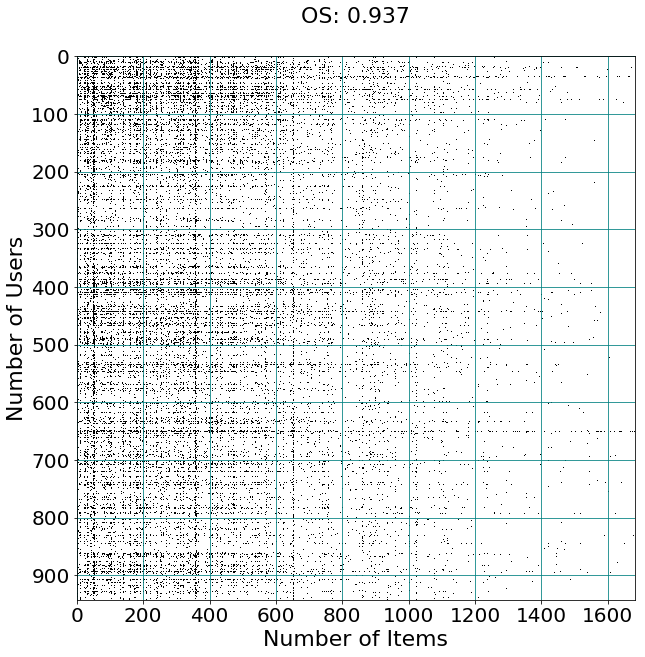

In [10]:
# Visualizing Matrix Sparsity
time_zero = time.time();

%matplotlib inline

OS = calculateOverallSparsityMeasure(R);

fig, ax = plt.subplots(figsize = (10,10));

ax.spy(R, aspect='auto');

#plt.xlabel("Number of Items (Total: {})".format(R.shape[1]-1), fontsize = 30)
#plt.ylabel("Number of Users (Total: {})".format(R.shape[0]-1), fontsize = 30)
plt.xlabel("Number of Items", fontsize = 22)
plt.ylabel("Number of Users", fontsize = 22)
plt.yticks(np.arange(0, R.shape[0], 100))
plt.margins(tight = True)
plt.title('OS: {:0.3f}'.format(OS), fontsize = 22)
plt.grid(color = 'teal', linestyle = '-')
#plt.title("OS: " + str(OS) + '\n', fontsize = 24)
plt.tick_params(axis='both', which='major', bottom = True, top = False, labelsize=20, labelbottom = True, labeltop = False)


print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'unsortedUtilityMatrix.png')

print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h1>Sorting Utility Matrix</h1>
<p>In order to study how sparsity can influence our algorithm, we need to create an utility matrix in a way that it is more dense near low indexes elements (top left corner of matrix) and less dense new high indexes elements (bottom right corner). This will give us the ability to chop the matrix on a given sparsity measure.

In [11]:
#Auxiliary Functions

global usersSparsity;
global usersSortedFlag;
global itemsSparsity;
global itemsSortedFlag;

def InitializeUsersSparsity():
    global usersSparsity;
    global usersSortedFlag;
    usersSparsity = np.zeros(R.shape[0]);
    usersSortedFlag = False; # If users are sorted by USS, flag turns True
    
def InitializeItemsSparsity():
    global itemsSparsity;
    global itemsSortedFlag; 
    itemsSparsity = np.zeros(R.shape[1]);
    itemsSortedFlag = False;

<h2>Sorting Users</h2>
<p>We start sorting our users given the following user specific sparsity measure (USS) as follows: 
<p> $USS = 1-\frac{n_u}{\max{u \in U} (n_u)}$
<p>where $n_u$ is the amount of evaluations a specific user $u$ has given $U$.

In [12]:
# Auxiliary Functions
def calculateUsersSpecificSparsityMeasure(matrix):
    """Calculates an array of User Specific Sparsity (USS) measure based on:
        USS = 1 - #u / max (#u), where #u is the number of items rated
        by user u"""
    ussArray = np.zeros(matrix.shape[0]); # Size argument
    
    count = 0;
    for user in matrix:
        ussArray[count] = np.count_nonzero(user);
        count += 1;
        
    maxNumberOfEvaluations = np.amax(ussArray)
    count = 0;
    for user in ussArray:
        ussArray[count] = 1-float(ussArray[count])/maxNumberOfEvaluations;
        count += 1;
        
    return ussArray;

def sortUsersBySparsity(matrix): #returns matrix, usersSortedIndex;
    """ Sort Utility Matrix by Users Sparsity
        Returns sorted matrix and usersSparsity array"""
    global usersSparsity;
    global usersSortedFlag;
    if not usersSortedFlag:
        print "[*] Calculating USS for every user...";
        usersSparsity = calculateUsersSpecificSparsityMeasure(matrix);
        usersSortedFlag = True;
        print "[*] USS calculated.";
    
    usersSparsity = calculateUsersSpecificSparsityMeasure(matrix);    
    usersSortedIndex = np.argsort(usersSparsity);
    
    #print "UsersSparsity SHAPE: ", usersSparsity.shape
    #print "usersSortedIndex SHAPE: ", usersSortedIndex.shape
    #print "usersSortedIndex MIN: ", np.min(usersSortedIndex)
    #print "usersSortedIndex MAX: ", np.max(usersSortedIndex)
    
    global usersIds;
    #print "usersIds SHAPE: ", usersIds.shape
    
    usersIds = usersIds[usersSortedIndex];
    matrix = matrix[usersSortedIndex];
    
    return matrix;

In [63]:
#########################################################
# Run this cell if you want to reset
# the utility matrix
#########################################################
time_zero = time.time();

R = InitializeUtilityMatrix();
R = FillUtilityMatrix();
InitializeUsersSparsity(); # Set usersSortedFlag to False
print "Elapsed time: ", time.time()-time_zero;

Elapsed time:  12.9516329765


In [13]:
# Initializing users sparsity array
time_zero = time.time();
InitializeUsersSparsity(); # Set usersSortedFlag to False

print "Elapsed time: ", time.time()-time_zero;

Elapsed time:  9.51290130615e-05


In [14]:
# Sorting Users by Sparsity
time_zero = time.time();

# Calculating users specific sparsity array
if not usersSortedFlag:
    usersSparsity = calculateUsersSpecificSparsityMeasure(R);
    usersSortedFlag = True;

# Saving USS Variables
saveVariable('usersSparsityArray', usersSparsity);

R = sortUsersBySparsity(R);

print "Utility Matrix sorted by users.";
print "Utility Matrix shape: ", R.shape;

print "Elapsed time: ", time.time()-time_zero;

# 100k Aprox. 3 s
# 10M Aprox. 27000 s

[*] Saving variable to ./Results/Variables/100k/usersSparsityArray file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
Utility Matrix sorted by users.
Utility Matrix shape:  (943, 1682)
Elapsed time:  0.0374591350555


<h3>Visualizing Users-Sorted Utility Matrix</h3>

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.291332006454


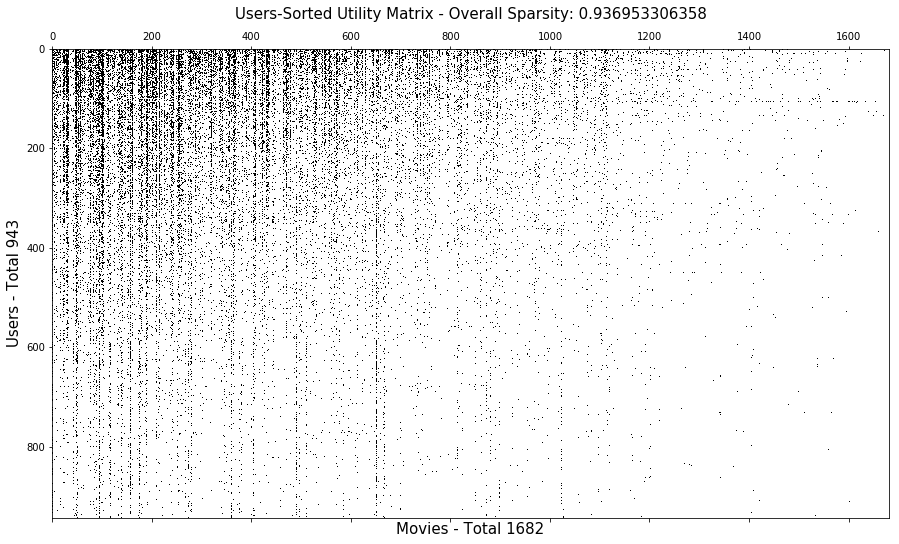

In [15]:
# Visualizing Users Sorted Matrix Sparsity
time_zero = time.time();

%matplotlib inline

OS = calculateOverallSparsityMeasure(R);
fig, ax = plt.subplots(figsize = (15,15));

ax.spy(R);

plt.xlabel("Movies - Total "+str(R.shape[1]), fontsize = 15)
plt.ylabel("Users - Total "+str(R.shape[0]), fontsize = 15)
plt.title("Users-Sorted Utility Matrix - Overall Sparsity: " + str(OS), fontsize = 15)

# Saving Figure
print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'usersSortedUtilityMatrix.png')

print "[+] Results saved."

plt.title("Users-Sorted Utility Matrix - Overall Sparsity: " + str(OS), fontsize = 15)

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h2>Sorting Items</h2>

<p>We then move to sorting our items given the following item specific sparsity measure (ISS) as follows: 
<p> $ISS = 1 - \frac{n_i}{\max{i \in I} (n_i)}$
<p>where $n_i$ is the amount of evaluations a specific user $u$ has given $I$.

In [16]:
def calculateItemsSpecificSparsityMeasure(matrix):
    """Calculates an array of Items Specific Sparsity (ISS) measure based on:
        ISS = 1 - #i / max (#i), where #i is the number of users who rated
        item u"""
    
    issArray = np.zeros(np.transpose(matrix.shape[0]));
    issArray = calculateUsersSpecificSparsityMeasure(np.transpose(matrix));
    
    return issArray;


def sortItemsBySparsity(matrix): #returns matrix, itemsSparsity;
    """ Sort Utility Matrix by Items Sparsity
        Returns sorted matrix and itemsSparsity array"""
    global itemsSparsity;
    global itemsSortedFlag;
    if not itemsSortedFlag:
        itemsSparsity = calculateItemsSpecificSparsityMeasure(matrix);
        itemsSortedFlag = True;
    
    itemsSortedIndex = np.argsort(itemsSparsity);
    
    global moviesIds;
    moviesIds = moviesIds[itemsSortedIndex];
    matrix = (matrix.T[itemsSortedIndex]).T;    
    
    return matrix;

In [17]:
#########################################################
# Run this cell if you want to reset
# the utility matrix
#########################################################
# time_zero = time.time();

# R = InitializeUtilityMatrix();
# R = FillUtilityMatrix();
# print "Elapsed time: ", time.time()-time_zero;

In [17]:
# Initializing Items Sparsity Array    
time_zero = time.time();

InitializeItemsSparsity(); # Set itemsSortedFlag to False

print "Elapsed time: ", time.time()-time_zero;

Elapsed time:  0.000110149383545


In [18]:
time_zero = time.time();

# Calculating users specific sparsity array
if not itemsSortedFlag:
    itemsSparsity = calculateItemsSpecificSparsityMeasure(R);
    itemsSortedFlag = True;

# Saving sorted users specific sparsity array
saveVariable('itemsSparsityArray', itemsSparsity);

R = sortItemsBySparsity(R);

print "Elapsed time: ", time.time()-time_zero;

# 100k Aprox. 166 s
# 10M Aprox. 27000 s

[*] Saving variable to ./Results/Variables/100k/itemsSparsityArray file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
Elapsed time:  0.0476739406586


<h3>Visualizing Items-Sorted Utility Matrix</h3>

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.226728916168


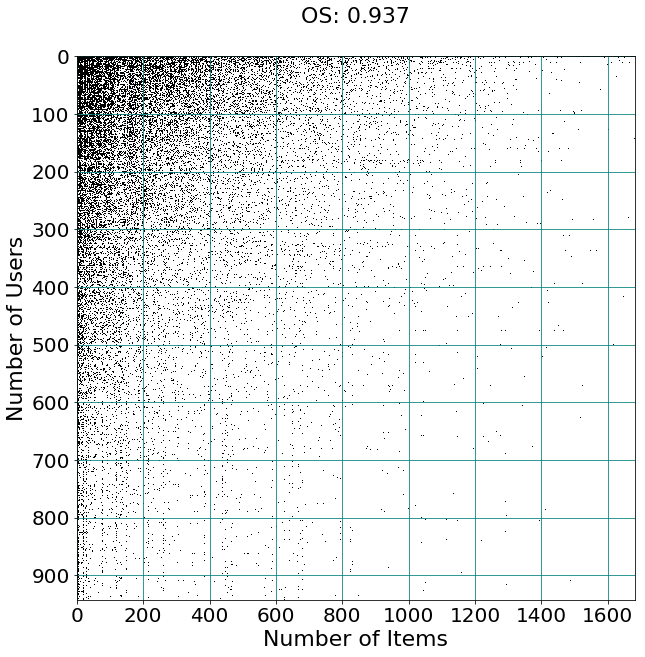

In [19]:
# Visualizing Items Sorted Matrix Sparsity
time_zero = time.time();

%matplotlib inline

'''
fig, ax = plt.subplots(figsize = (10,10));

ax.spy(R, aspect='auto');

#plt.xlabel("Number of Items (Total: {})".format(R.shape[1]-1), fontsize = 30)
#plt.ylabel("Number of Users (Total: {})".format(R.shape[0]-1), fontsize = 30)
plt.xlabel("Number of Items", fontsize = 30)
plt.ylabel("Number of Users", fontsize = 30)
plt.yticks(np.arange(0, R.shape[0], 100))

plt.title('OS: {:0.3f}'.format(OS), fontsize = 24)
plt.grid(color = 'teal', linestyle = '-')
#plt.title("OS: " + str(OS) + '\n', fontsize = 24)
plt.tick_params(axis='both', which='major', bottom = True, top = False, labelsize=24, labelbottom = True, labeltop = False)
'''

OS = calculateOverallSparsityMeasure(R);
fig, ax = plt.subplots(figsize = (10,10));

ax.spy(R, aspect='auto');

plt.xlabel("Number of Items", fontsize = 22)
plt.ylabel("Number of Users", fontsize = 22)
plt.yticks(np.arange(0, R.shape[0], 100))

plt.title('OS: {:0.3f}'.format(OS), fontsize = 22)
plt.grid(color = 'teal', linestyle = '-')
#plt.title("OS: " + str(OS) + '\n', fontsize = 24)
plt.tick_params(axis='both', which='major', bottom = True, top = False, labelsize=20, labelbottom = True, labeltop = False)
plt.margins(tight = True)
print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'itemsAndUsersSortedUtilityMatrix.png')
print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h2>Creating Utility Matrix Back-up</h2>
In case you want to go back to an utility matrix state, use the cells below

In [20]:
########################################################
# Creating back-up! Run this cell only if you want to 
# save your current utility matrix state.
########################################################
time_zero = time.time()

R_copy = np.copy(R);
print "Utility Matrix Copy Shape: ", R_copy.shape;
print "Elapsed time: ", time.time()-time_zero;

print R_copy

Utility Matrix Copy Shape:  (943, 1682)
Elapsed time:  0.00276398658752
[[ 5.  0.  0. ...,  0.  0.  0.]
 [ 4.  2.  3. ...,  0.  0.  3.]
 [ 5.  4.  5. ...,  0.  0.  0.]
 ..., 
 [ 5.  3.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  4.  0. ...,  0.  0.  0.]]


In [53]:
# Getting back-up point
time_zero = time.time();
R = np.copy(R_copy)
print "Utility Matrix shape: ", R.shape
print "Elapsed time: ", time.time()-time_zero;
print R;

Utility Matrix shape:  (943, 1682)
Elapsed time:  0.00705981254578
[[ 5.  0.  0. ...,  0.  0.  0.]
 [ 4.  2.  3. ...,  0.  0.  3.]
 [ 5.  4.  5. ...,  0.  0.  0.]
 ..., 
 [ 5.  3.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  4.  0. ...,  0.  0.  0.]]


<h1>Chopping Utility Matrix</h1>
In order to analyse how our overall sparsity changes by reducing users or items, we can chop our utility matrix according to 2 strategies:
- Chopping Users/Items by Specific Sparsity: we will only maintain those users/items with specific sparsity less than a defined threshold;
- Chopping Users/Items by Quantity: we will only maintain a certain amount of users/items according to our desired utility matrix shape.

In [21]:
# Auxiliary Functions

def chopUsersByUSS(matrix, lastUserUSS):
    """Returns utility matrix after dropping users with USS greater than 
    the last USS."""  
    
    if lastUserUSS <= 0:
        return matrix[0:1];
    
    if lastUserUSS >= 1:
        return matrix;
                
    usersSparsityArray = calculateUsersSpecificSparsityMeasure(matrix);    
    usersSparsityArray = np.sort(usersSparsityArray);       
        
    if lastUserUSS > usersSparsityArray[-1]:        
        return matrix;    
    
    lastUserIndex = np.argmax(usersSparsityArray >= lastUserUSS);           
    
    return matrix[:lastUserIndex]; 

def chopItemsByISS(matrix, lastItemISS):
    """Returns utility matrix after dropping items with ISS greater than 
    the last ISS."""
    
    if lastItemISS >= 1:
        return matrix;
    if lastItemISS <= 0:
        tempMatrix = np.array(matrix[:,0]);
        tempMatrix = np.reshape(tempMatrix, (matrix.shape[0],1));
        return tempMatrix;
        
    itemsSparsityArray = calculateItemsSpecificSparsityMeasure(matrix);    
    itemsSparsityArray = np.sort(itemsSparsityArray);        
    
    if lastItemISS > itemsSparsityArray[-1]:
        return matrix;
    
    lastItemIndex = np.argmax(itemsSparsityArray >= lastItemISS);
    
    tempMatrix = np.array(matrix[:,:lastItemIndex]);
    
    if lastItemIndex == 0:        
        tempMatrix = np.reshape(tempMatrix, (matrix.shape[0],1));
        
    return tempMatrix;
        
@np.vectorize    
def calculateOverallSparsityBySpecific(lastUserUSS, lastItemISS):
    """Calculates OS after chopping utility matrix given the last user's 
    and item's specific sparsity."""
    # Creating a copy of utility matrix so we don't 
    # mess with the original one (just in case)
    matrix = np.copy(R); 
    
    # Chopping utility matrix
    matrix = chopItemsByISS(matrix, lastItemISS);    
    matrix = chopUsersByUSS(matrix, lastUserUSS);        
    
    # Calculating chopped utility matrix overall sparsity
    result = calculateOverallSparsityMeasure(matrix);
    
    return result;    

<h2>Analysing Users Quantity given USS threshold</h2>
What happens to our users amount if we only keep those users with USS value less than a specific threshold ?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  1.6126999855


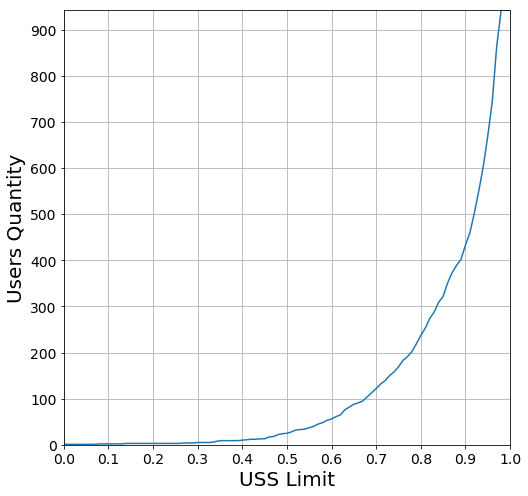

In [55]:
time_zero = time.time();

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])

usersQuantity = []
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopUsersByUSS(chopedMatrix, sparsityLimit);
    usersQuantity.append(chopedMatrix.shape[0]);

%matplotlib inline

#plt.plot(sparsityChops, usersQuantity, '-')
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sparsityChops, usersQuantity)
ax.axis([0, sparsityChops[-1], 0, usersQuantity[-1]])
ax.grid(True)
ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
ax.set_yticks([x for x in xrange (0, usersQuantity[-1], 100)])
ax.set_xlabel('USS Limit', fontsize = 20)
ax.set_ylabel('Users Quantity', fontsize = 20)
#ax.set_title('Users Quantity x Users Sparsity Limit', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=14)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'usersQuantityXusersSparsity.png')
print "[+] Results saved.";
print "Elapsed time: ", time.time()-time_zero;

In [56]:
# Getting Users Quantity by Sparsity
time_zero = time.time();

usersQuantityThreshold = 900;

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopUsersByUSS(chopedMatrix, sparsityLimit);
    if chopedMatrix.shape[0] > usersQuantityThreshold:
        break;
    
print "USS limit to have ", usersQuantityThreshold, " users: ", sparsityLimit;
print "Number of users: ", chopedMatrix.shape[0];
print "Elapsed time: ", time.time()-time_zero;

USS limit to have  900  users:  0.98
Number of users:  943
Elapsed time:  1.17929792404


<h2>Analysing Items Quantity given ISS threshold</h2>
What happens to our items amount if we only keep those items with ISS value less than a specific threshold ?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.606954097748


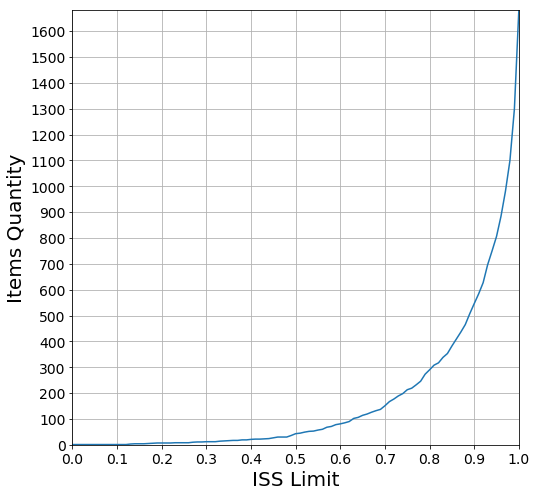

In [57]:
time_zero = time.time();

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])

itemsQuantity = []
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopItemsByISS(chopedMatrix, sparsityLimit);
    itemsQuantity.append(chopedMatrix.shape[1]);

%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(sparsityChops, itemsQuantity)
ax.axis([0, sparsityChops[-1], 0, itemsQuantity[-1]])
ax.grid(True)
ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

ax.set_xlabel('ISS Limit', fontsize = 20)
ax.set_ylabel('Items Quantity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.set_title('Items Quantity x Items Sparsity Limit', fontsize = 15)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'itemsQuantityXitemsSparsity.png')
print "[+] Results saved.";
print "Elapsed time: ", time.time()-time_zero;

In [58]:
# Getting Items Quantity by Sparsity
time_zero = time.time();

itemsQuantityThreshold = 900;

sparsityChops = np.array([x/100.0 for x in xrange(0, 101, 1)])
for sparsityLimit in sparsityChops:
    chopedMatrix = np.copy(R);
    chopedMatrix = chopItemsByISS(chopedMatrix, sparsityLimit);
    if chopedMatrix.shape[1] > itemsQuantityThreshold:
        break;
    
print "ISS limit to have ", itemsQuantityThreshold, " items: ", sparsityLimit;
print "Number of items: ", chopedMatrix.shape[1];
print "Elapsed time: ", time.time()-time_zero;

ISS limit to have  900  items:  0.97
Number of items:  981
Elapsed time:  1.48077297211


<h2>Chopping Utility Matrix by Specific Sparsity</h2>
What happens to our utility matrix OS if we chop items and/or users by their specific sparsity?

[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.343918800354


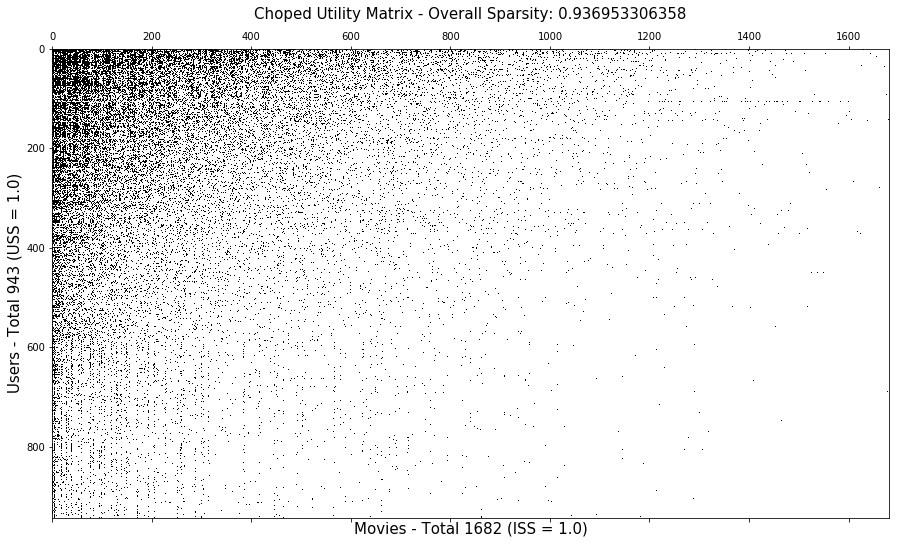

In [22]:
# Visualizing Items Sorted Matrix Sparsity
time_zero = time.time();

%matplotlib inline

usersUSSlimit = 1.0;
itemsISSlimit = 1.0;

chopedMatrix = np.copy(R);
chopedMatrix = chopUsersByUSS(chopedMatrix, usersUSSlimit);
chopedMatrix = chopItemsByISS(chopedMatrix, itemsISSlimit);

OS = calculateOverallSparsityMeasure(chopedMatrix);
fig, ax = plt.subplots(figsize = (15,15));

ax.spy(chopedMatrix);

plt.xlabel("Movies - Total "+str(chopedMatrix.shape[1]) + " (ISS = " + str(itemsISSlimit) + ")", fontsize = 15)
plt.ylabel("Users - Total "+str(chopedMatrix.shape[0]) + " (USS = " + str(usersUSSlimit) + ")", fontsize = 15)
plt.title("Choped Utility Matrix - Overall Sparsity: " + str(OS), fontsize = 15)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'chopedUtilityMatrix.png')

print "[+] Results saved."

print "Elapsed time: ", time.time()-time_zero; # Aprox. 5 s

<h3>Visualizing OS effect due to Specific Sparsity changes</h3>

[*] Saving variable to ./Results/Variables/100k/OS-3d-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/OS-3d-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/OS-3d-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving 3d-chopSparsityMeasures.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  7.09260416031


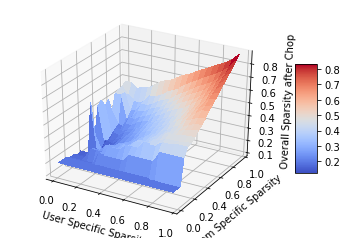

In [60]:
time_zero = time.time();

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.array([a/100.0 for a in xrange(1,100,5)])
B = np.array([b/100.0 for b in xrange(1,100,5)])

A, B = np.meshgrid(A, B)

#Processing data
Z = calculateOverallSparsityBySpecific (A, B);

var_A_filename = 'OS-3d-A_meshgrid.csv'
var_B_filename = 'OS-3d-B_meshgrid.csv'
var_Z_filename = 'OS-3d-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel('Overall Sparsity after Chop')

filename = '3d-chopSparsityMeasures.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

In [149]:
granularity = 5

X = np.array([a/100.0 for a in xrange(0,101, granularity)]) # user
Y = np.array([b/100.0 for b in xrange(100,-1, -granularity)]) # item
#print X
#print Y

Zline = np.array([])
firstLine = True

for y in xrange(len(Y)):
    Zline = np.array([]);
    for x in xrange(len(X)):
        element = calculateOverallSparsityBySpecific (X[x], Y[y]); #user, item
        Zline = np.append(Zline, element)
    if firstLine:
        Z = np.array([Zline])
        firstLine = False
    else:
        Z = np.append(Z, [Zline], axis = 0)    
    
    #print Zline
#print Zline.shape
print Z.shape
#print Z

(21, 21)


In [187]:
#Plotting 2-D evaluation graph

granularity = 1

# Make data.
A = np.array([a/100.0 for a in xrange(1,100,granularity)])
B = np.array([b/100.0 for b in xrange(1,100,granularity)])

A, B = np.meshgrid(A, B)

#Processing data
Z = calculateOverallSparsityBySpecific (A, B);


In [188]:
print Z.shape
print calculateOverallSparsityBySpecific(0.1, 0.1)

(99, 99)
0.195540308748


[*] Saving 2d-ISSxUSSxOS.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.


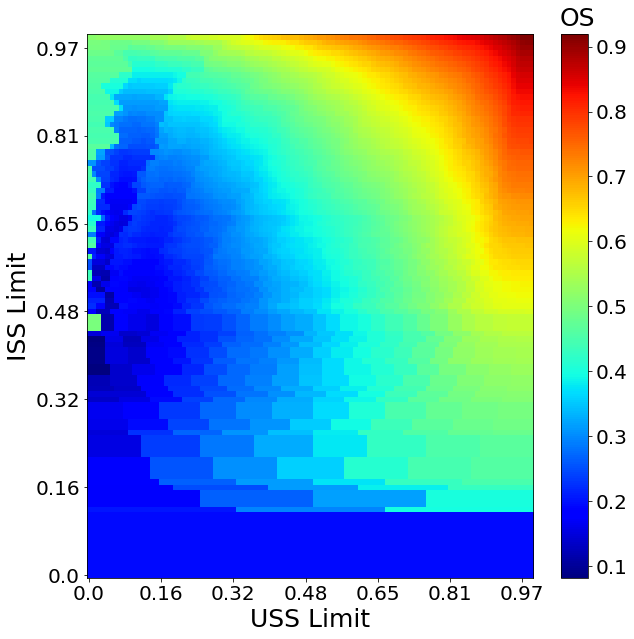

In [228]:
%matplotlib inline

A = np.array([a/100.0 for a in xrange(0,100,granularity)])
B = np.array([b/100.0 for b in xrange(0,100,granularity)])

fig, ax = plt.subplots(figsize=(10,10))

cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

numberOfTicks = 6

labels = [x/float(Z.shape[0]) for x in xrange(0,Z.shape[0],Z.shape[0]/numberOfTicks)]
for l in xrange(len(labels)):
    labels[l] = float("{0:.2f}".format(labels[l]))
    
plt.xticks(np.arange(0, Z.shape[0], Z.shape[0]/numberOfTicks))
plt.yticks(np.arange(0, Z.shape[1], Z.shape[0]/numberOfTicks))

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Setting Labels
tick_fontsize = 20
label_fontsize = 25
ax.set_xlabel('USS Limit', fontsize = label_fontsize)
ax.set_ylabel('ISS Limit', fontsize = label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

cbar = fig.colorbar(cax)
cbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)



# Saving figure
filename = '2d-ISSxUSSxOS.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
print "[+] Results saved.";

In [120]:
#print calculateOverallSparsityBySpecific(0.1, 0.9)
print Z

[[ 0.19554031  0.19554031  0.19554031 ...,  0.19554031  0.19554031
   0.19554031]
 [ 0.19554031  0.19554031  0.19554031 ...,  0.19554031  0.19554031
   0.19554031]
 [ 0.19554031  0.19554031  0.19554031 ...,  0.19554031  0.19554031
   0.19554031]
 ..., 
 [ 0.49541284  0.49541284  0.49541284 ...,  0.89650442  0.89650442
   0.89650442]
 [ 0.49863512  0.49863512  0.49863512 ...,  0.90593263  0.90601405
   0.90601405]
 [ 0.51540832  0.51540832  0.52118644 ...,  0.91909243  0.91909243
   0.91909243]]


<h1>Testing Algorithms According to Sparsity</h1>
Now that we've set how we can change our OS due to specific sparsities, we can analyse how a recommender system is affected if we work on a certain sparsity zone.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from surprise.accuracy import mae, rmse

class SAERecSys:

    def __init__(self, input_matrix,
                 numNeurons = 16,                  
                 loss_metric = 'mse',
                 learning_rate = 0.001):
        
        # Always call base method before doing anything.
        self.input_matrix = input_matrix;
        self.num_neurons = numNeurons;                        
        self.loss_metric = loss_metric;
        self.learning_rate = learning_rate;  
        self.cv_metrics_values = {};
        
        # Splitting train and test set
        #self.x_train, self.x_test = train_test_split(self.input_matrix);
        
    def fit(self, verbose = False):
        
        # Splitting train and test set
        self.x_train, self.x_test = train_test_split(self.input_matrix);
        
        # Scaling input to range (-1,1)
        self.xNormScaler = MinMaxScaler(feature_range = (-1,1))
        self.xNormScaler.fit(self.x_train)

        self.x_norm_train = self.xNormScaler.transform(self.x_train)
        self.x_norm_test = self.xNormScaler.transform(self.x_test)

        #Setting autoencoder
        self.inputDim = self.x_norm_train.shape[1] #Number of items

        self.autoencoder = Sequential([
                                  Dense(self.num_neurons, activation = 'selu', kernel_initializer = 'uniform', input_dim = self.inputDim),
                                  Dense(self.inputDim, activation = 'tanh', kernel_initializer = 'uniform')
                                 ])

        #SGD = optimizers.SGD(lr=0.5, momentum=0.00, decay=0.0, nesterov=False)
        #Adam = optimizers.Adam(lr=0.0005, decay = 0.00001)
        self.Adam = optimizers.Adam(lr = self.learning_rate)

        self.autoencoder.compile(optimizer = self.Adam, loss = self.loss_metric, metrics=['mae'])
        #autoencoder.summary()
        
        self.earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto')

        time_zero = time.time()

        self.fitHistory = self.autoencoder.fit(
                                    self.x_norm_train, 
                                    self.x_norm_train, 
                                    epochs = 2000,
                                    verbose = 0,
                                    shuffle = True,
                                    validation_data = (self.x_norm_test, self.x_norm_test), 
                                    callbacks = [self.earlyStopping])

        self.predicted_matrix = self.predict(self.input_matrix);
        
        
        #print('Time to fit model: '+str(time.time()-time_zero)+' seconds')
        
        return self    
        
    def cross_validate(self, n_folds = 10, metrics = ['rmse', 'mae', 'mrre'], verbose = True):
        for metric in metrics:
            self.cv_metrics_values[metric] = [];
        
        for i in xrange(n_folds):
            time_zero = time.time();
            self.fit(self.input_matrix);            
            fold_mae = self.evaluate('mae');
            fold_rmse = self.evaluate('rmse');
            fold_mrre = self.evaluate('mrre');
            self.cv_metrics_values['rmse'].append(fold_rmse)
            self.cv_metrics_values['mae'].append(fold_mae)
            self.cv_metrics_values['mrre'].append(fold_mrre)
            
            
            #print "Elapsed time for fold " + str(i) + ": ", time.time()-time_zero;
        
        return self.cv_metrics_values;
        
    def evaluate(self, metric = 'rmse'):
        
        if metric == 'rmse':
            return np.sqrt(mean_squared_error(self.x_test, self.predict(self.x_test)));
        elif metric == 'mae':
            return mean_absolute_error (self.x_test, self.predict(self.x_test));
        elif metric == 'mrre':
            return MRRE(self.x_test, self.predict(self.x_test))
        
        else:
            return "Invalid Metric: " + str(metric);
        
        
    def predict(self, matrix):
        # Creating scaler model
        matrix_norm_scaler = MinMaxScaler(feature_range = (-1,1));        
        
        # Fitting scaler model
        matrix_norm_scaler.fit(matrix);        
        
        # Creating normalized matrix
        matrix_norm = matrix_norm_scaler.transform(matrix);

        # Predicting output for normalized input matrix
        output = self.autoencoder.predict(matrix_norm);

        # Denormalizing output
        output_denormal = matrix_norm_scaler.inverse_transform(output);

        # Rounding denormalized output to nearest integer
        matrix_predicted = np.rint(output_denormal);
        
        return matrix_predicted

        #print R_predicted
        
    def estimate(self, u, i): # Estimates an evaluation from a given user to an item        
        return self.predicted_matrix[u][i]
    


Using TensorFlow backend.


<h3>Auxiliary Function</h3>

In [24]:
#Importing Libs
from surprise import NMF
from surprise import SVD
from surprise import KNNBasic
from surprise import Dataset
from surprise import evaluate, print_perf
from sklearn.model_selection import train_test_split

import surprise
#Creating dataset to use in surprise lib format

def MRRE(matrix, predicted_matrix):
    sum_error = 0;
    eval_quantity = 0;
        
    if len(matrix.shape) == 1:
        for i in xrange(len(matrix)):        
            if matrix[i] != 0:                
                sum_error += (matrix[i]-predicted_matrix[i])**2;
                eval_quantity += 1;
    
        return np.sqrt(sum_error/float(eval_quantity));
        
    
    for i in xrange(len(matrix)):
        for j in xrange(len(matrix[i])):
            if matrix[i][j] != 0:                
                sum_error += (matrix[i][j]-predicted_matrix[i][j])**2;
                eval_quantity += 1;
    
    return np.sqrt(sum_error/float(eval_quantity));

def RMSE(matrix, predicted_matrix):
    return np.sqrt(mean_squared_error(R, R_predicted))

def MAE(matrix, predicted_matrix):
    return mean_absolute_error(matrix, predicted_matrix);

def createUtilityMatrixPandasDataset(matrix):
    new_dataframe = pd.DataFrame()
    global usersIds;
    global moviesIds;
    
    stringUsersIds = [];
    stringMoviesIds = [];
    stringEvaluations = [];
    
    for userCount in xrange(len(matrix)):
        for itemCount in xrange(len(matrix[userCount])):
            if matrix[userCount][itemCount] != 0:
                stringUsersIds.append(usersIds[userCount]);
                stringMoviesIds.append(moviesIds[itemCount]);
                stringEvaluations.append(str(int(matrix[userCount][itemCount])));
    
    new_dataframe['userId'] = stringUsersIds;    
    new_dataframe['movieId'] = stringMoviesIds;
    new_dataframe['rating'] = stringEvaluations;
    return new_dataframe;

###################################################################
# Keep in mind the number of folds used in cross validation!
###################################################################

def getAlgorithmEvaluations(algorithmName, USSLimit, ISSLimit, number_of_folds = 10, number_of_epochs = 20):
    algorithms = [KNNBasic(),  SVD(n_epochs = number_of_epochs), NMF()];
    algorithmsNames = np.array(['KNNBasic', 'SVD', 'NMF', 'SAE']);
    
    if algorithmName not in algorithmsNames:
        print algorithmName, " is not on the algorithms list.";
        return -1;
    
    global R;
    chopedMatrix = np.copy(R);
    chopedMatrix = chopUsersByUSS(chopedMatrix, USSLimit);
    chopedMatrix = chopItemsByISS(chopedMatrix, ISSLimit);

    OS = calculateOverallSparsityMeasure(chopedMatrix);
    shape = chopedMatrix.shape;
    
    if algorithmName in ['SVD', 'NMF']:
    
        df = createUtilityMatrixPandasDataset(chopedMatrix);

        tempFilePath = results_path+'Variables/'+'tempData.csv';
        with open(tempFilePath, "w") as fout:
            head = 'userId,movieId,rating\n';
            fout.write(head);
            for registerCount in xrange(df.shape[0]):
                line = str(df['userId'][registerCount])+','+str(df['movieId'][registerCount])+','+str(df['rating'][registerCount])+'\n';
                fout.write(line);

        r = surprise.dataset.Reader(sep=',', skip_lines=1);
        data = Dataset.load_from_file(tempFilePath, r);    
        data.split(n_folds=number_of_folds)

        # Evaluate performances of our algorithm on the dataset.
        algo = algorithms[np.where(algorithmsNames == algorithmName)[0][0]];

        perf = evaluate(algo, data, measures=['RMSE', 'MAE'], verbose=0)
        
        maeMeans = np.mean(perf['MAE'])
        maeStd = np.std(perf['MAE'])
        rmseMeans = np.mean(perf['RMSE'])
        rmseStd = np.std(perf['RMSE'])
        
        #trainset, testset = train_test_split(data)
        #algo.fit(trainset)
        #prediction = algo.test(testset)
            
        #print algo.predict
            
        #global moviesIds;
        #bestUserPrediction = [];
        
        #num_eval = 0;
        #est_sum = 0;
        #for itemDatafileIndex in xrange(len(chopedMatrix[0])):            
        #    est_sum +=  (algo.predict(df["userId"][0],df["movieId"][itemDatafileIndex], r_ui = int(df["rating"][itemDatafileIndex])))[3]
        #    num_eval += 1;
            
        #print algo.predict(df["userId"][0],df["movieId"][itemDatafileIndex], r_ui = int(df["rating"][itemDatafileIndex]))
        #print est_sum/num_eval;
        #print bestUserPrediction
        #mrre = MRRE(bestUser, bestUserPrediction);
    
    elif algorithmName in ['SAE']:
        SAE_RS = SAERecSys(chopedMatrix);
        SAE_RS.cross_validate();
        maeMeans = np.mean(SAE_RS.cv_metrics_values['mae']);
        maeStd = np.std(SAE_RS.cv_metrics_values['mae']);
        rmseMeans = np.mean(SAE_RS.cv_metrics_values['rmse']);
        rmseStd = np.std(SAE_RS.cv_metrics_values['rmse']);
        #mrre = MRRE(chopedMatrix[0], SAE_RS.predict(chopedMatrix[0]));
        
    else:
        return "Unsuported Algorithm: " + algorithmName;
    
    returnArray = [algorithmName, USSLimit, ISSLimit, shape[0], shape[1], OS, maeMeans, maeStd, rmseMeans, rmseStd];
    
    return returnArray;


In [25]:
print getAlgorithmEvaluations('SVD', 0.5, 0.5);

['SVD', 0.5, 0.5, 25, 328, 0.34304878048780485, 0.71685165507172788, 0.023725170794411412, 0.91526631925147961, 0.032242832886626938]


In [31]:
print getAlgorithmEvaluations('SAE', 0.6, 0.6);

['SAE', 0.6, 0.6, 56, 377, 0.419145509662751, 1.2122205380826072, 0.042588371953146208, 1.5994852348542512, 0.049462397490867727]


In [32]:

print getAlgorithmEvaluations('SAE', 0.5, 0.5);
#print len(moviesIds)


['SAE', 0.5, 0.5, 25, 328, 0.34304878048780485, 1.2341027874564456, 0.047934048937114997, 1.5875817795334879, 0.037478671061994095]


In [33]:
print getAlgorithmEvaluations('SAE', 0.4, 0.4);

['SAE', 0.4, 0.4, 10, 251, 0.250199203187251, 1.0686586985391768, 0.10067951469149428, 1.41291527926627, 0.11560695796015398]


In [34]:
print getAlgorithmEvaluations('SAE', 0.3, 0.3);

['SAE', 0.3, 0.3, 5, 274, 0.256934306569343, 0.94142335766423346, 0.044109655739389894, 1.324679840103792, 0.069963233696760538]


In [36]:
print getAlgorithmEvaluations('SAE', 0.2, 0.2);

['SAE', 0.2, 0.2, 3, 185, 0.2324324324324324, 0.25297297297297294, 0.050290609079407599, 0.50025487327217599, 0.052134774770896487]


<h2>Getting Number of Epochs for SVD</h2>

In [ ]:
epochs = [e for e in xrange(10,201,10)]

RESULTS = []
TIMES = []

for epoch in epochs:
    time_zero = time.time()
    RESULT = getAlgorithmEvaluations('SVD',0.2,0.2,number_of_epochs = epoch)
    RESULTS.append(RESULT);
    TIMES.append(time.time()-time_zero)

saveVariable('RESULTS_EPOCH_STUDY', RESULTS)
saveVariable('EPOCHS_USED_IN_STUDY', epochs)
bot.sendMessage("Finished getting RMSE_SVD results for all epochs.");

In [ ]:

RMSE_SVD_EPOCHS = []
for result in RESULTS:
    RMSE_SVD_EPOCHS.append(result[8])

print RMSE_SVD_EPOCHS
    
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(epochs, RMSE_SVD_EPOCHS)
#ax.axis([0, RMSE_SVD_EPOCHS[-1], 0, epochs[-1]])
ax.grid(True)
#ax.set_xticks([x/100.0 for x in xrange (0, 110, 10)])
#ax.set_yticks([x for x in xrange (0, itemsQuantity[-1], 100)])

ax.set_xlabel('Epochs', fontsize = 20)
ax.set_ylabel('RMSE-SVD', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
#ax.set_title('Items Quantity x Items Sparsity Limit', fontsize = 15)

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'RMSE_SVD_EPOCHS.png')
print "[+] Results saved.";
bot.sendMessage("Finished getting results for all epochs.", results_path+'Figures/'+dataset+'RMSE_SVD_EPOCHS.png');

In [314]:
#Testing Functions
time_zero = time.time()
#print getAlgorithmEvaluations('NMF', 1.0, 1.0);
#print getAlgorithmEvaluations('SVD', 1.0, 1.0);
print getAlgorithmEvaluations('SAE', 1.0, 1.0);
print "Elapsed time: ", time.time()-time_zero

<surprise.dataset.DatasetAutoFolds instance at 0x4fc1b7a0>
['SVD', 1.0, 1.0, 944, 1683, 0.9370575143257097, 0.73290482700765724, 0.0048131266409736414, 0.93028300373413819, 0.0046881757594039661]
Elapsed time:  82.1655700207


In [311]:
#print getAlgorithmEvaluations('NMF', 0.9, 1.0);
print getAlgorithmEvaluations('SVD', 1.0, 1.0);
#print getAlgorithmEvaluations('SAE', 0.9, 1.0);

<surprise.dataset.DatasetAutoFolds instance at 0x5d5345a8>
['SVD', 1.0, 1.0, 944, 1683, 0.9370575143257097, 0.76362565529717963, 0.003278957261632378, 0.97498758506622174, 0.0040782683807064814]


In [315]:
#print getAlgorithmEvaluations('NMF', 0.6, 1.0);
#print getAlgorithmEvaluations('SVD', 0.6, 1.0);
print getAlgorithmEvaluations('SAE', 0.2, 0.2);

['SAE', 0.2, 0.2, 3, 185, 0.23423423423423428, 0.2094418763910289, 0.0089730748096246305, 0.71709644112497961, 0.013822272037180193]


In [198]:
#print getAlgorithmEvaluations('NMF', 1.0, 0.9);
print getAlgorithmEvaluations('SVD', 1.0, 0.9);
#print getAlgorithmEvaluations('SAE', 1.0, 0.9);

<surprise.dataset.DatasetAutoFolds instance at 0x64594098>
['SVD', 1.0, 0.9, 944, 546, 0.8435501645247407, 0.71754279654365938, 0.0077949559481116353, 0.91253676464329148, 0.01132065088221504]


In [199]:
#print getAlgorithmEvaluations('NMF', 1.0, 0.6);
print getAlgorithmEvaluations('SVD', 1.0, 0.6);
#print getAlgorithmEvaluations('SAE', 1.0, 0.6);

<surprise.dataset.DatasetAutoFolds instance at 0x6d72dcb0>
['SVD', 1.0, 0.6, 944, 81, 0.6640772128060264, 0.71322086854857913, 0.01073559289915357, 0.91156142656071848, 0.014520132936095715]


In [195]:
#print getAlgorithmEvaluations('NMF', 0.9, 0.9);
#print getAlgorithmEvaluations('SVD', 0.9, 0.9);
print getAlgorithmEvaluations('SAE', 0.9, 0.9);

['SAE', 0.9, 0.9, 433, 658, 0.7597555753666019, 0.21024326011863398, 0.0078398624183559189, 0.71884664272470622, 0.011871422459248769]


In [196]:
#print getAlgorithmEvaluations('NMF', 0.6, 0.6);
#print getAlgorithmEvaluations('SVD', 0.6, 0.6);
print getAlgorithmEvaluations('SAE', 0.6, 0.6);

['SAE', 0.6, 0.6, 56, 377, 0.41938234179613487, 0.21406286191929264, 0.0064898188573404448, 0.72442205580708419, 0.0090840519518120572]


<h3>Getting Algorithm Evaluations</h3>

In [26]:
bot = Bot('JFGS')
bot.sendMessage('oi')

In [37]:
#print algorithmsResults
filename = 'algorithmsResultsVector';
fullpath = results_path+'Variables/'+dataset+filename;
print "[*] Saving " + filename + " variable to " + fullpath
np.save(arr=algorithmsResults, file=fullpath)
print "[+] Results saved.";
bot.sendMessage('Results saved on file '+fullpath+'.npy')

[*] Saving algorithmsResultsVector variable to ./Results/Variables/100k/algorithmsResultsVector
[+] Results saved.


In [55]:
arr = np.array(np.load(fullpath+'.npy' ))

bot.sendMessage('Results succesfully loaded')

IOError: [Errno 2] No such file or directory: './Results/Figures/100k/2d-SAE-RMSE.png.npy'

In [ ]:
######################################################

time_zero = time.time();

#algorithmsNames = ['SVD', 'KNNBasic', 'NMF'];
algorithmsNames = ['SAE']; # Which algorithms you would like to evaluate
X = np.array([x/100.0 for x in xrange(5, 101, 50)]);
Y = np.array([x/100.0 for x in xrange(5, 101, 50)]);

Z_axis = np.zeros((len(X), len(Y)));


for alg in algorithmsNames:
    time_one = time.time();
    bot.sendMessage('Starting algorithm evaluation');
    
    for x_index in xrange(len(X)):
        bot.sendMessage('Starting x_index ' + x_index + '/' + len(X));    
        for y_index in xrange(len(Y)): 
            result = getAlgorithmEvaluations(alg, X[x_index], Y[y_index]);            
            Z_axis[x_index][y_index] = result[8];
    
    message = "Elapsed time for "+ str(alg) + ": "+ str(time.time()-time_one) + " s";
    print message;
    bot.sendMessage(message);
    var_Z_filename = 'Z_'+ alg + 'meshgrid_.csv'
    saveVariable(var_Z_filename, Z_axis);
    bot.sendMessage('Variable Sucessfully saved');

######################################################


In [ ]:
X_bkp = np.copy(X)
Y_bkp = np.copy(Y)
Z_bkp = np.copy(Z_axis)

In [73]:


for var, obj in locals().items():
    print var, sys.getsizeof(obj)

__ 96
telegram 56
_57 72
dataset_path 67
itemsISSLimits 112
Sequential 904
usersSparsity 7640
calculateItemsSpecificSparsityMeasure 120
KILO 24
moviesIds 13552
_i20 6128
ModelCheckpoint 904
_i59 72
MEGA 24
usersSortedFlag 24
_62 96
_61 96
fig 64
_i 92
alg 40
exit 64
evaluate 120
SVD 104
FillUtilityMatrix 120
os 56
surprise 56
X 256
_i50 5624
_sh 56
MRRE 120
usersUSSLimits 112
_i13 6612
_i12 1964
_i11 4120
_i10 2676
_i17 3808
_i16 3028
_i15 1996
_i14 716
x 24
_i19 1652
_i18 736
OS 24
_dh 80
arr 752
Dense 904
_i56 104
calculateUsersSpecificSparsityMeasure 120
InitializeItemsSparsity 120
result 152
_i72 92
MAE 120
saveVariable 120
Bot 104
itemsSortedFlag 24
filename 52
load_model 120
_i44 1268
train_test_split 120
_i28 4096
_i29 144
_i26 212
_i27 208
_i24 20988
_i25 332
_i22 8448
_i23 20644
var_Z_filename 80
_i21 1524
plt 56
_i48 104
_i49 136
calculateOverallSparsityBySpecific 64
__builtins__ 56
_i45 5628
_i46 5636
_i47 5628
_i40 296
_i41 1268
_i42 5628
_i43 296
InitializeUtilityMatrix 12

In [ ]:
var_Z_filename = './Results/Variables/100k/Z_'+ 'SAE' + 'meshgrid_.csv'
Z_axis = joblib.load(var_Z_filename)
#X = np.array([x/100.0 for x in xrange(5, 101, 1)]);
#Y = np.array([x/100.0 for x in xrange(5, 101, 1)]);
print Z_axis.shape
bot.sendMessage('Variable Loaded with dimensions '+str(Z_axis.shape));

[*] Saving 2d-SAE-RMSE.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.


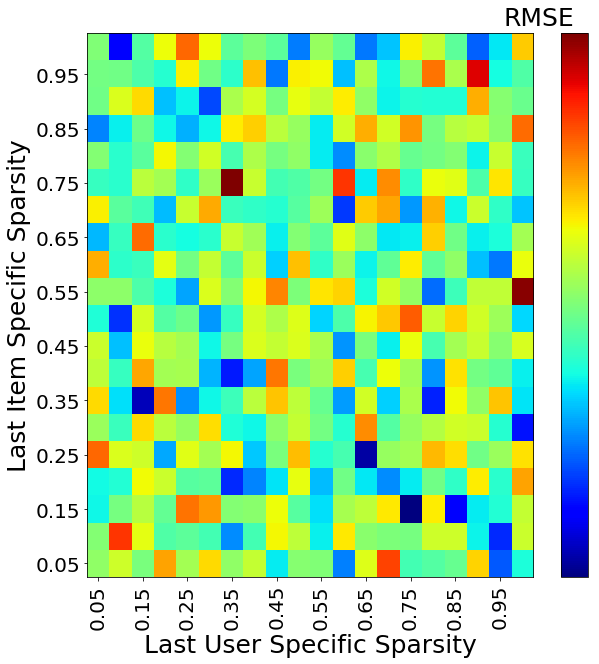

In [60]:
#Plotting 2-D evaluation graph
%matplotlib inline

algoName = 'SAE'
evaluationParameter = 'RMSE'
#cmapping = "viridis
#cmapping = "Spectral"
#cmapping = "seismic"
#cmapping = "CMRmap"
#cmapping = "CMRmap"
cmapping = "jet"

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(Z_axis[:,:], cmap=cmapping, aspect="auto")
plt.gca().invert_yaxis()

n_ticks = 10

plt.xticks(np.arange(0, len(X), len(X)/n_ticks))
plt.yticks(np.arange(0, len(Y), len(Y)/n_ticks))
X_ticks = [X[x] for x in xrange(0,len(X),len(X)/n_ticks)]
ax.set_xticklabels(X_ticks)
ax.set_yticklabels(X_ticks)

tick_fontsize = 20
label_fontsize = 25

# Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
cbar = fig.colorbar(cax, ticks = [x/100.0 for x in xrange(0,1000,5)])

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('RMSE', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

# Saving figure
filename = '2d-'+algoName+'-'+evaluationParameter+'.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
#bot.sendMessage('Grafico: ', fullpath)
print "[+] Results saved.";


In [ ]:
time_zero = time.time();

#algorithmsNames = ['SVD', 'KNNBasic', 'NMF'];
algorithmsNames = ['NMF']; # Which algorithms you would like to evaluate
usersUSSLimits = np.array([x/100.0 for x in xrange(10, 101, 2)]);
itemsISSLimits = np.array([x/100.0 for x in xrange(10, 101, 2)]);

algorithmsResults = [];
messages = []

for alg in algorithmsNames:
    
    bot.sendMessage('Starting algorithm evaluation');
    time_one = time.time();
    for userUSS in usersUSSLimits:
        message = '[' + str(time.time()-time_one) + '] Starting USS ' + str(userUSS)
        bot.sendMessage(message);
        for itemISS in itemsISSLimits: 
            message = '[' + str(time.time()-time_one) + '] Starting ISS ' + str(itemISS)
            bot.sendMessage(message);
            result = getAlgorithmEvaluations(alg, userUSS, itemISS)            
            algorithmsResults.append(result);
    
    message = "Elapsed time for "+ str(alg) + ": "+ str(time.time()-time_one) + " s";
    bot.sendMessage(message);
    print message
    #messages.append(message)
    #bot.sendMessage(messages)
    
algorithmsResults = np.array(algorithmsResults);

message = "Algorithms evaluations have finished. "
bot.sendMessage(message)
print "Elapsed time: ", time.time()-time_zero;

In [ ]:
#Creating dataframe to save evaluations and saving it to file.
algorithmsDataframe = pd.DataFrame()

#  algorithmsResults data:
#  [Algorithm, USSLimit, ISSLimit, shape[0], shape[1], OS, maeMeans, maeStd, rmseMeans, rmseStd];
algorithmsDataframe['Algorithm'] = algorithmsResults[:,0];
algorithmsDataframe['USS'] = algorithmsResults[:,1];
algorithmsDataframe['ISS'] = algorithmsResults[:,2];
algorithmsDataframe['users'] = algorithmsResults[:,3];
algorithmsDataframe['items'] = algorithmsResults[:,4];
algorithmsDataframe['OS'] = algorithmsResults[:,5];
algorithmsDataframe['MAEmeans'] = algorithmsResults[:,6];
algorithmsDataframe['MAEstd'] = algorithmsResults[:,7];
algorithmsDataframe['RMSEmeans'] = algorithmsResults[:,8];
algorithmsDataframe['RMSEstd'] = algorithmsResults[:,9];

path = results_path+'Variables/'+dataset+'NMF/'
filename = 'NMF-algorithmsResults.csv';
print "[*] Saving " + filename + " file to " + path + " folder..."
algorithmsDataframe.to_csv(path+filename);
message = 'AlgorithmsDataframe saved'
bot.sendMessage(message)
print "[+] Results saved."

In [ ]:

filename = 'algorithmsResults.csv'
fullpath = path+'SAE/'+'SAE-' + filename
print fullpath
algorithmsDataframe.to_csv(fullpath);

In [27]:
algorithmsDataframe = pd.read_csv(results_path+'Variables/'+dataset+'SVD/'+'SVD-algorithmsResults.csv')

In [28]:
print algorithmsDataframe.tail()
#print algorithmsDataframe.loc[np.argmin(algorithmsDataframe.RMSEmeans)]

     Unnamed: 0 Algorithm  USS   ISS  users  items        OS  MAEmeans  \
356         356       SVD  1.0  0.80    943    290  0.781808  0.709718   
357         357       SVD  1.0  0.85    943    382  0.808709  0.712696   
358         358       SVD  1.0  0.90    943    546  0.843384  0.717730   
359         359       SVD  1.0  0.95    943    806  0.879317  0.722607   
360         360       SVD  1.0  1.00    943   1682  0.936953  0.731654   

       MAEstd  RMSEmeans   RMSEstd  
356  0.007443   0.904332  0.009925  
357  0.008078   0.909146  0.007739  
358  0.005643   0.914215  0.007275  
359  0.005595   0.919267  0.008207  
360  0.007006   0.928689  0.007760  


In [208]:
time_zero = time.time()
ussProfiles = {
    'Very Tight': '0.68',
    'Tight' : '0.78',
    'Medium': '0.89',
    'Loose' : '0.97',
    'Very Loose': '0.98'}
ussProfilesNames = ['Very Tight', 'Tight', 'Medium', 'Loose', 'Very Loose']
issProfiles = {
    'Very Tight': '0.63',
    'Tight' : '0.75',
    'Medium': '0.86',
    'Loose' : '0.95',
    'Very Loose': '0.97'}
issProfilesNames = ['Very Tight', 'Tight', 'Medium', 'Loose', 'Very Loose']

print "=== SVD ===\n"    

for alg in algorithmsNames:
    print "\n",alg," - RMSE:"
    for uProfileName in ussProfilesNames:
        line = "\\textbf{"+uProfileName+"}";        
        for iProfileName in issProfilesNames:                        
            for register in xrange(len(algorithmsDataframe['Algorithm'])):
                if algorithmsDataframe['Algorithm'][register] == alg and algorithmsDataframe['USS'][register] == ussProfiles[uProfileName] and algorithmsDataframe['ISS'][register] == issProfiles[iProfileName]:
                    #print  uProfileName,'\t& ',iProfileName,'\t&\t$',algorithmsDataframe['RMSEmeans'][register][:5], '\pm',  algorithmsDataframe['RMSEstd'][register][:5],'$', '\\\\';
                    line = line + " & $" + algorithmsDataframe['RMSEmeans'][register][:5] + ' \pm ' +  algorithmsDataframe['RMSEstd'][register][:5]+'$'
        line = line + " \\\\"            
        print line
        
"""print "\n=== MAE ===\n"    
for alg in algorithmsNames:
    print alg," - MAE: "
    for uProfileName in ussProfiles:
        for iProfileName in issProfiles:
            for register in xrange(len(algorithmsDataframe['Algorithm'])):
                if algorithmsDataframe['Algorithm'][register] == alg and algorithmsDataframe['USS'][register] == ussProfiles[uProfileName] and algorithmsDataframe['ISS'][register] == issProfiles[iProfileName]:
                    print  uProfileName,'\t& ',iProfileName,'\t&\t$',algorithmsDataframe['MAEmeans'][register][:5], '\pm',  algorithmsDataframe['MAEstd'][register][:5],'$', '\\\\';
"""                 
print "Elapsed time: ", time.time()-time_zero;                    

=== SVD ===


SVD  - RMSE:
\textbf{Very Tight} \\
\textbf{Tight} \\
\textbf{Medium} \\
\textbf{Loose} \\
\textbf{Very Loose} \\
Elapsed time:  0.555946111679


<h2>Visualizing Algorihtms Evaluations</h2>

<h3> SAE - MAE</h3>

In [ ]:
# Making data arrays
A = np.array([])
B = np.array([])

Zline = np.array([])
algoName = 'SAE'
firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);
evaluationParameter = 'RMSEmeans'

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

#Z = np.append(Z, [Zline], axis = 0)


In [ ]:
#Plotting 2-D evaluation graph
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

plt.xticks(np.arange(0, len(A), 1))
plt.yticks(np.arange(0, len(B), 1))
ax.set_xticklabels(A)
ax.set_yticklabels(B)

tick_fontsize = 20
label_fontsize = 25

# Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
cbar = fig.colorbar(cax)

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('RMSE', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

# Saving figure
filename = '2d-'+algoName+'-'+evaluationParameter+'.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
bot.sendMessage('Grafico: ', fullpath)
print "[+] Results saved.";


<h3>SVD - MAE</h3>

In [283]:
# Making data arrays
A = np.array([])
B = np.array([])

Zline = np.array([])
algoName = 'SVD'
firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);
evaluationParameter = 'RMSEmeans'

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)


In [256]:
bot = Bot('JFGS')


[*] Saving 2d-SVD-RMSEmeans.png figure to ./Results/Figures/100k/ folder...
[+] Results saved.


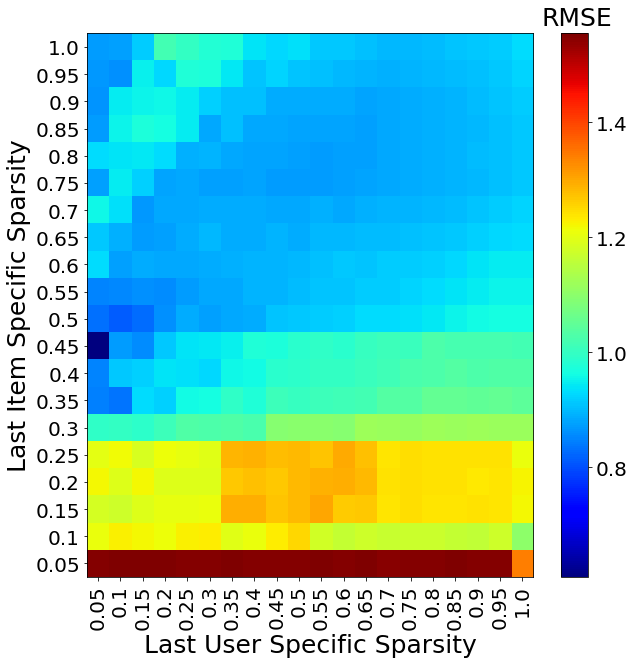

In [284]:
#Plotting 2-D evaluation graph
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(Z[:,:], cmap="jet", aspect="auto")
plt.gca().invert_yaxis()

plt.xticks(np.arange(0, len(A), 1))
plt.yticks(np.arange(0, len(B), 1))
ax.set_xticklabels(A)
ax.set_yticklabels(B)

tick_fontsize = 20
label_fontsize = 25

# Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
cbar = fig.colorbar(cax)

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('RMSE', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)

# Saving figure
filename = '2d-'+algoName+'-'+evaluationParameter+'.png';
fullpath = results_path+'Figures/'+dataset+filename;
print "[*] Saving " + filename + " figure to " + results_path+'Figures/'+dataset + " folder..."
plt.savefig(fullpath);
bot.sendMessage('Grafico: ', fullpath)
print "[+] Results saved.";


[*] Saving variable to ./Results/Variables/100k/SVD-MAE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-MAE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-MAE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.41921710968


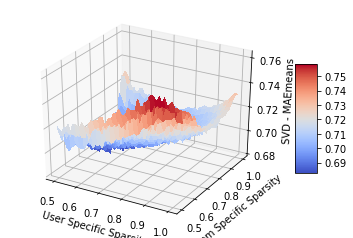

In [238]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'SVD'
evaluationParameter = 'MAEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'SVD-MAE-A_meshgrid.csv'
var_B_filename = 'SVD-MAE-B_meshgrid.csv'
var_Z_filename = 'SVD-MAE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+algoName+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>SVD - RMSE</h3>

[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/SVD-RMSE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.501820087433


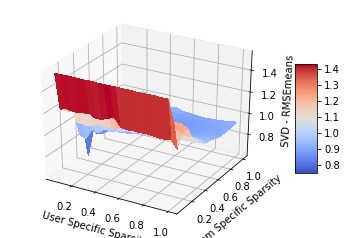

In [308]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'SVD'
evaluationParameter = 'RMSEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'SVD-RMSE-A_meshgrid.csv'
var_B_filename = 'SVD-RMSE-B_meshgrid.csv'
var_Z_filename = 'SVD-RMSE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>NMF - MAE</h3>

[*] Saving variable to ./Results/Variables/100k/NMF-MAE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-MAE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-MAE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.324208021164


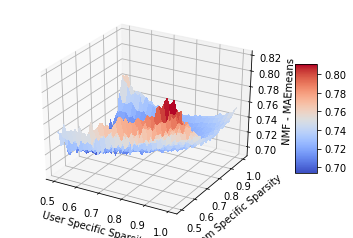

In [240]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'NMF'
evaluationParameter = 'MAEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
# Saving variables for future use
var_A_filename = 'NMF-MAE-A_meshgrid.csv'
var_B_filename = 'NMF-MAE-B_meshgrid.csv'
var_Z_filename = 'NMF-MAE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;

<h3>NMF - RMSE</h3>

[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-A_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-B_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving variable to ./Results/Variables/100k/NMF-RMSE-Z_meshgrid.csv file...
[*] Removing existing file...
[+] Existing file removed.
[+] File saved.
[*] Saving results to./Results/Figures/100k/ folder...
[+] Results saved.
Elapsed time:  0.364863872528


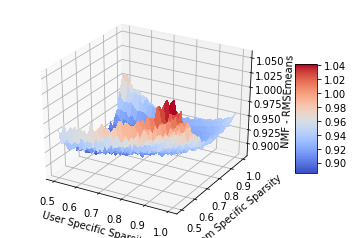

In [241]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

%matplotlib inline
#%matplotlib notebook

time_zero = time.time();

# Make data.
algoName = 'NMF'
evaluationParameter = 'RMSEmeans'

A = np.array([])
B = np.array([])
#Z = np.array([[]])
Zline = np.array([])

firstLine = True;
lastUSSValue = float(algorithmsDataframe['USS'][0]);

for register in xrange(algorithmsDataframe.shape[0]):
    if algorithmsDataframe['Algorithm'][register] == algoName:
        ussValue = float(algorithmsDataframe['USS'][register]);
        issValue = float(algorithmsDataframe['ISS'][register]);
        evaluationValue = float(algorithmsDataframe[evaluationParameter][register]);
                       
        #print "ISS: ", issValue, "LISS: ", lastISSValue, "\tEvaluation: ", evaluationValue
        if ussValue not in A:
            A = np.append(A, ussValue);                        
                    
        if issValue not in B:
            B = np.append(B, issValue);            
            
        if lastUSSValue == ussValue:            
            Zline = np.append(Zline, evaluationValue)            
            
        else:                        
            if firstLine:
                Z = np.array([Zline])
                firstLine = False;
            else:
                Z = np.append(Z, [Zline], axis = 0)
            Zline = np.array([evaluationValue]);
        
        lastUSSValue = ussValue;

Z = np.append(Z, [Zline], axis = 0)
A, B = np.meshgrid(A, B)

# Saving variables for future use
var_A_filename = 'NMF-RMSE-A_meshgrid.csv'
var_B_filename = 'NMF-RMSE-B_meshgrid.csv'
var_Z_filename = 'NMF-RMSE-Z_meshgrid.csv'
saveVariable(var_A_filename, A);
saveVariable(var_B_filename, B);
saveVariable(var_Z_filename, Z);

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')


#surf = ax.plot_surface(A, B, Z, rstride=1, cstride=1, cmap=cm.viridis)
surf = ax.plot_surface(A, B, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Set plot info
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('User Specific Sparsity')
ax.set_ylabel('Item Specific Sparsity')
ax.set_zlabel(algoName+' - ' + evaluationParameter)

#plt.show()

print "[*] Saving results to" + results_path + 'Figures/'+dataset + " folder..."
plt.savefig(results_path+'Figures/'+dataset+'-'+evaluationParameter+'.png');
print "[+] Results saved.";

print "Elapsed time: ", time.time()-time_zero;